<a href="https://colab.research.google.com/github/qwerlarlgus/CNN-Cats-Dogs/blob/main/4_2_aug_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline

In [ ]:
!ls -l

total 111588
drwx------ 5 root root      4096 Jan 25 00:49 drive
drwxr-xr-x 1 root root      4096 Jan 20 17:27 sample_data
-rw------- 1 root root 114250866 Jan 21 04:51 training_data.zip


In [ ]:
!cp ./drive/MyDrive/training_data.zip .

cp: cannot stat './drive/MyDrive/training_data.zip': No such file or directory


In [ ]:
!unzip training_data.zip


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test_data/cat.10023.jpg  
  inflating: test_data/cat.1004.jpg  
  inflating: test_data/cat.10078.jpg  
  inflating: test_data/cat.10090.jpg  
  inflating: test_data/cat.10100.jpg  
  inflating: test_data/cat.10105.jpg  
  inflating: test_data/cat.10106.jpg  
  inflating: test_data/cat.10116.jpg  
  inflating: test_data/cat.10122.jpg  
  inflating: test_data/cat.10169.jpg  
  inflating: test_data/cat.102.jpg   
  inflating: test_data/cat.10201.jpg  
  inflating: test_data/cat.1021.jpg  
  inflating: test_data/cat.10223.jpg  
  inflating: test_data/cat.10239.jpg  
  inflating: test_data/cat.10250.jpg  
  inflating: test_data/cat.1026.jpg  
  inflating: test_data/cat.10287.jpg  
  inflating: test_data/cat.10293.jpg  
  inflating: test_data/cat.10307.jpg  
  inflating: test_data/cat.10309.jpg  
  inflating: test_data/cat.10380.jpg  
  inflating: test_data/cat.10384.jpg  
  inflating: test_data/cat.10404.jpg  
  inflating: test_data/cat.10421

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [ ]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

In [ ]:
batch_size = 50
num_classes = 2
epochs = 150
input_shape = (150, 150, 3)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
# encode wine type labels
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[0:5], train_labels_enc[0:5])

['cat', 'cat', 'cat', 'dog', 'cat'] [0 0 0 1 0]


In [ ]:
train_datagen = ImageDataGenerator( zoom_range=0.3, rotation_range=50,  # rescale=1./255,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator() # rescale=1./255

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)

In [ ]:

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

vgg = vgg16.VGG16(include_top=False, weights='imagenet',
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
import pandas as pd
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3b0b1d87f0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b0b1ac128>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b0b1accc0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3b004b74a8>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b004bc550>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b004c1390>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f3b004c1710>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b004ca7f0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b004cf780>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f3b004cac50>,block3_conv3,False


In [ ]:
print("Trainable layers:", vgg_model.trainable_weights)

Trainable layers: []


(1, 4, 4, 512)


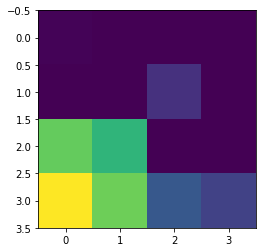

In [ ]:
bottleneck_feature_example = vgg.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape)
plt.imshow(bottleneck_feature_example[0][:,:,0])

In [ ]:
def get_bottleneck_features(model, input_imgs):
    
    features = model.predict(input_imgs, verbose=0)
    return features

In [ ]:
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs_scaled)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs_scaled)

print('Train Bottleneck Features:', train_features_vgg.shape, 
      '\tValidation Bottleneck Features:', validation_features_vgg.shape)

Train Bottleneck Features: (3000, 8192) 	Validation Bottleneck Features: (1000, 8192)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(64, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 8192)              14714688  
_________________________________________________________________
dense_3 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 15,243,265
Trainable params: 528,577
Non-trainable params: 14,714,688
____________________________________

In [ ]:
history = model.fit_generator(train_generator,  epochs=100,
                              validation_data=val_generator,  verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 19s 180ms/step - loss: 6.1593 - accuracy: 0.5348 - val_loss: 1.7291 - val_accuracy: 0.7520
Epoch 2/100
100/100 [==============================] - 18s 178ms/step - loss: 3.0868 - accuracy: 0.6238 - val_loss: 1.0788 - val_accuracy: 0.8050
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 2.2056 - accuracy: 0.6574 - val_loss: 0.8443 - val_accuracy: 0.8160
Epoch 4/100
100/100 [==============================] - 18s 180ms/step - loss: 1.7171 - accuracy: 0.6801 - val_loss: 0.6478 - val_accuracy: 0.8480
Epoch 5/100
100/100 [==============================] - 18s 179ms/step - loss: 1.4121 - accuracy: 0.6841 - val_loss: 0.5501 - val_accuracy: 0.8610
Epoch 6/100
100/100 [==============================] - 18s 179ms/step - loss: 1.2484 - accuracy: 0.7032 - val_loss: 0.4950 - val_accuracy: 0.8660
Epoch 7/100
100/100 [==============================] - 18s 180ms/step - loss: 1.0601 - accuracy: 0.7160 - val_loss: 0.4324 -

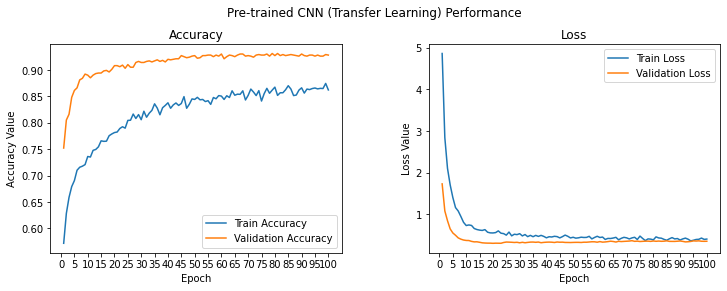

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('4-2-augpretrained_cnn.h5')